In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import h5py
import torch
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
np.set_printoptions(precision=2, suppress=False)

Building dataset with constant housing in time
Building dataset with constant housing in time
Building dataset with constant housing in time
Building dataset with constant housing in time
Building dataset with constant housing in time


Text(0, 0.5, 'Black')

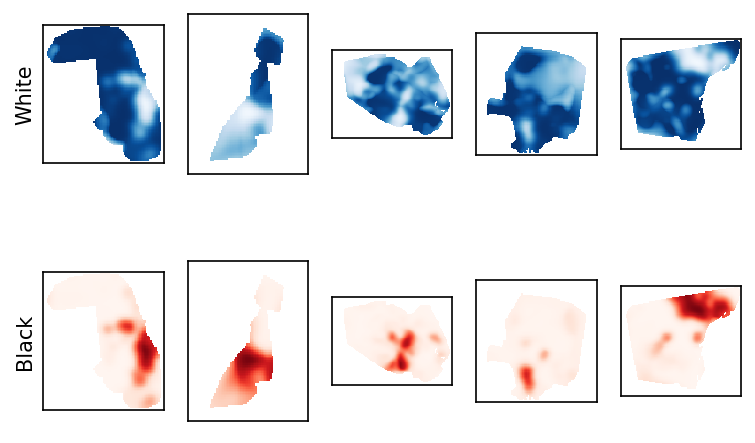

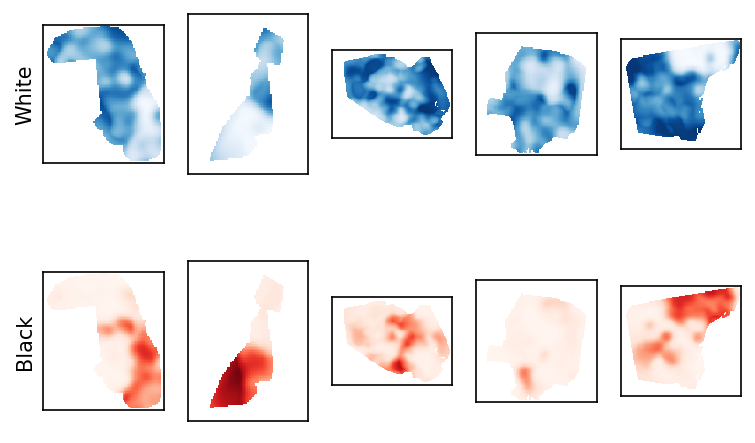

In [2]:
from data_processing import *
from pbnn import *
from torch.utils.data import ConcatDataset

def plot(ax, sample, vmax=None):
    ax[0].pcolormesh(sample['x'], sample['y'], sample['wb0'][0], cmap='Blues', vmax=1, vmin=0)
    ax[1].pcolormesh(sample['x'], sample['y'], sample['wb0'][1], cmap='Reds', vmax=1, vmin=0)
        
    for a in ax:
        a.set_aspect('equal')
        a.set(xticks=[], yticks=[])
    

housing_method='constant'
dataset = ConcatDataset([
    CensusDataset('cook_IL',housing_method=housing_method),
    CensusDataset('fulton_GA',housing_method=housing_method),
    CensusDataset('harris_TX',housing_method=housing_method),
    CensusDataset('la_CA',housing_method=housing_method),
    CensusDataset('wayne_MI',housing_method=housing_method),
])
fig, ax = plt.subplots(2, 5, dpi=150)
for i, ds in enumerate(dataset.datasets):
    ds.validate()
    plot(ax[:, i], dataset[i*40])
    
ax[0,0].set_ylabel(f'White')
ax[1,0].set_ylabel(f'Black')

fig, ax = plt.subplots(2, 5, dpi=150)
for i, ds in enumerate(dataset.datasets):
    ds.validate()
    plot(ax[:, i], dataset[i*40+30])
    
ax[0,0].set_ylabel(f'White')
ax[1,0].set_ylabel(f'Black')

$$ \dot{\phi_i } = \nabla \cdot (D_{ij} \nabla \phi_j + \Gamma_i \nabla^3 \phi_i ) + S_i $$

$$ \mathcal{L} = (\dot{\phi} - \dot{\hat{\phi}})^2 + \beta S_i^2 + \beta_{\Gamma} \Gamma^2 $$

Building dataset with constant housing in time


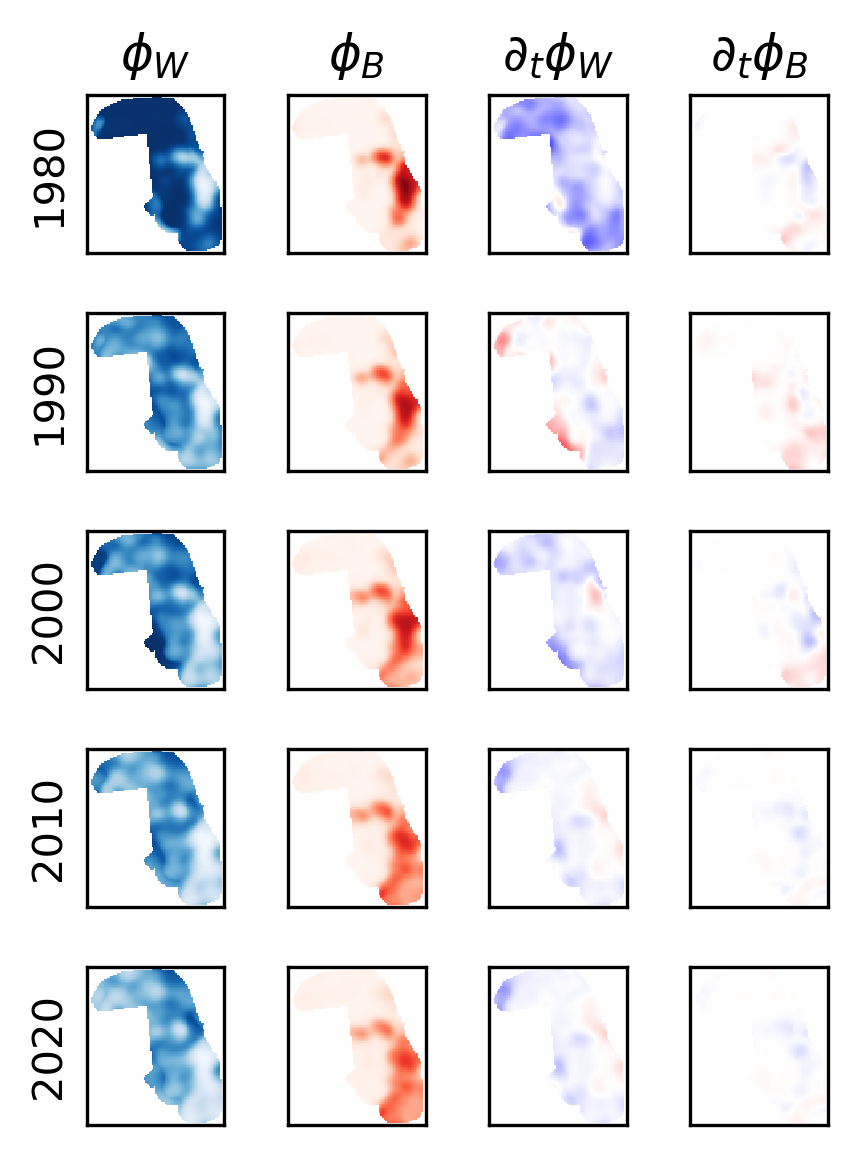

In [3]:
fig, ax = plt.subplots(5, 4, figsize=(3, 4), dpi=300)

county = 'cook_IL'
dataset = CensusDataset(county, housing_method='constant')
dataset.validate()

vmax = 0.1
for i in range(5):
    wb0 = dataset.wb(1980+i*10)
    wb1 = dataset.wb(1980+i*10+1)
    ax[i, 0].pcolormesh(dataset.x, dataset.y, wb0[0], vmin=0, vmax=1, cmap='Blues')
    ax[i, 1].pcolormesh(dataset.x, dataset.y, wb0[1], vmin=0, vmax=1, cmap='Reds')
    ax[i, 2].pcolormesh(dataset.x, dataset.y, wb1[0]-wb0[0], vmin=-vmax, vmax=vmax, cmap='bwr')
    ax[i, 3].pcolormesh(dataset.x, dataset.y, wb1[1]-wb0[1], vmin=-vmax, vmax=vmax, cmap='bwr')
    ax[i,0].set_ylabel(1980+i*10)

for a in ax.flatten():
    a.set(xticks=[], yticks=[], aspect='equal')
    
ax[0,0].set_title('$\phi_W$')
ax[0,1].set_title('$\phi_B$')
ax[0,2].set_title('$\partial_t \phi_W$')
ax[0,3].set_title('$\partial_t \phi_B$')
    
plt.tight_layout()

Building dataset with constant housing in time
Using vmax = 0
Si vmax = 0.0226638
Using vmax = 0
Si vmax = 0.0201188


  0%|          | 0/40 [00:00<?, ?it/s]

Using vmax = 0
Si vmax = 0.0401736
Target change after 40 years is: 0.112917
Predicted change after 40 years is: 0.0811349
MSE after 40 years is: 0.0298812


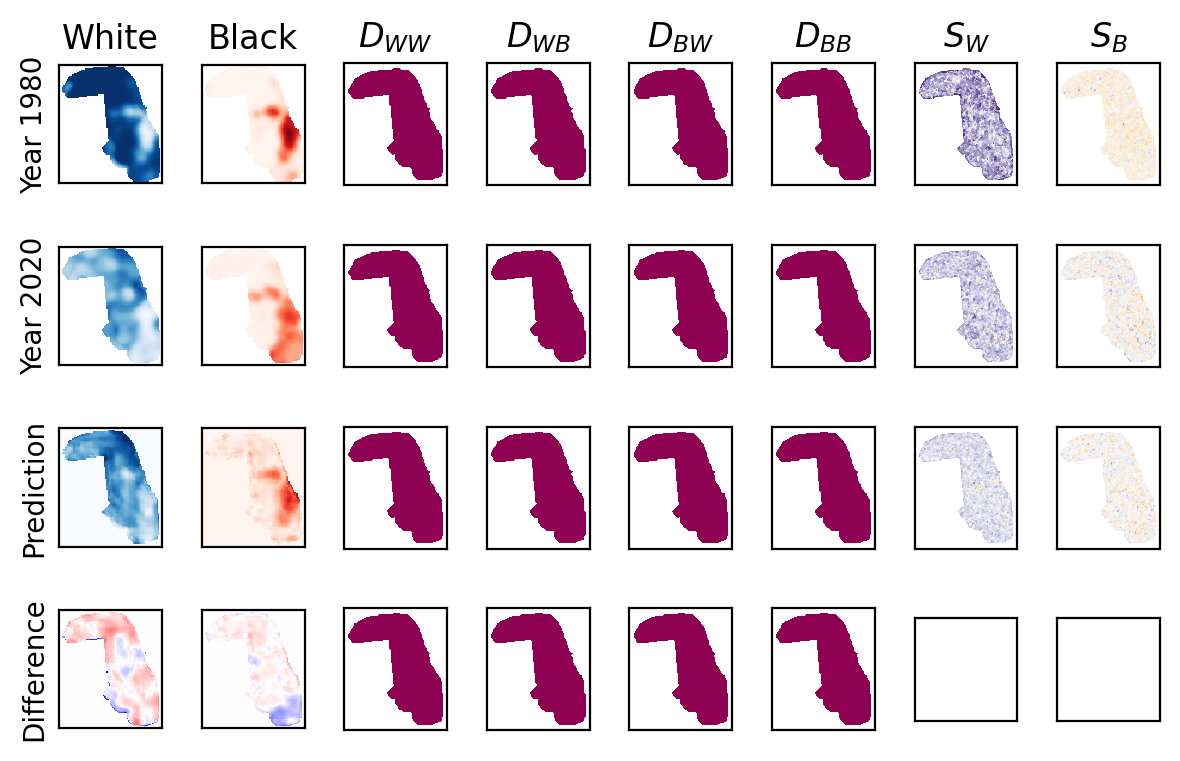

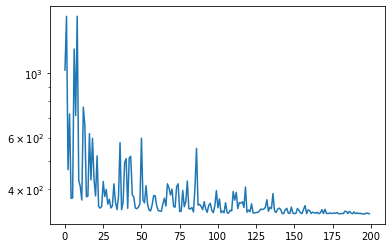

In [8]:
def plot(ax, sample, model, vmax=None):
    ax[0].pcolormesh(sample['x'], sample['y'], sample['wb0'][0], cmap='Blues', vmax=1, vmin=0)
    ax[1].pcolormesh(sample['x'], sample['y'], sample['wb0'][1], cmap='Reds', vmax=1, vmin=0)

    with torch.no_grad(), d_ad.stop_annotating():
        sample['wb0'] = sample['wb0'].to(device)
        params = model.forward(sample['wb0'][None],
                               sample['problem'].FctSpace,
                               (sample['x'], sample['y']))
        Dij = params['Dij'].detach().cpu().numpy()
        Si  = params['Si'].detach().cpu().numpy()
    
    if vmax is None:
        vmax = np.max(np.abs(Dij))
        print(f'Using vmax = {vmax:g}')

    for i in range(4):
        plot_mesh(ax[2+i], Dij[i], dataset.mesh, cmap='PiYG', vmin=-vmax, vmax=vmax)
    
    vmax = np.max(np.abs(Si))
    print(f'Si vmax = {vmax:g}')
    for i in range(2):
        plot_mesh(ax[6+i], Si[i], dataset.mesh, cmap='PuOr', vmin=-vmax, vmax=vmax)
        
    for a in ax:
        a.set_aspect('equal')
        a.set(xticks=[], yticks=[])
    
    ax[0].set_ylabel(f'Year {sample["t"]:g}')
    
    return sample['wb0'].detach().cpu().numpy(), Dij

from data_processing import *
from pbnn import *
from dolfin_problems import *

county = 'cook_IL'
dataset = CensusDataset(county,
                        get_dolfin=SociohydrodynamicsProblem,
                        housing_method='constant')
dataset.validate()

pipeline=9112009
#model = SourcedSymmetricPBNN().to(device)
model = SourcedOnlyPBNN().to(device)
info = torch.load(f'pipeline_{pipeline}/constant/{model.__class__.__name__}.ckpt', map_location='cpu')
model.load_state_dict(info['state_dict'])
model.train()

t0 = 1980
t1 = 2020
tmax = t1 - t0
dt = 1

dataset.validate()
sample = dataset[0]
mask = sample['mask']

fig, ax = plt.subplots(4, 8, dpi=200)

wb0, Dij0 = plot(ax[0], sample, model)
wb1, Dij1 = plot(ax[1], dataset[tmax], model)

with torch.no_grad(), d_ad.stop_annotating():
    sample['wb0'] = sample['wb0'].to(device)
    w0, b0, wb = model.simulate(sample, dataset.mesh, tmax, dt=dt)
    sample['wb0']= wb.cpu()
    sample['t'] += tmax

wb2, Dij2 = plot(ax[2], sample, model)
ax[2,0].set_ylabel('Prediction')

print(f'Target change after {tmax} years is: {np.mean((wb1[:, mask]-wb0[:, mask])**2):g}')
print(f'Predicted change after {tmax} years is: {np.mean((wb2[:, mask]-wb0[:, mask])**2):g}')
print(f'MSE after {tmax} years is: {np.mean((wb2[:, mask]-wb1[:, mask])**2):g}')

diff = wb2 - wb1
vmax = 1
ax[3, 0].pcolormesh(sample['x'], sample['y'], diff[0], cmap='bwr', vmin=-vmax, vmax=vmax)
ax[3, 1].pcolormesh(sample['x'], sample['y'], diff[1], cmap='bwr', vmin=-vmax, vmax=vmax)

diff = Dij2 - Dij0
vmax = 3*np.std(diff)
for i in range(4):
    plot_mesh(ax[3, 2+i], diff[i], dataset.mesh, cmap='PiYG', vmin=-vmax, vmax=vmax)
for a in ax[3]:
    a.set(aspect='equal', xticks=[], yticks=[])
ax[3, 0].set_ylabel('Difference')

ax[0,0].set_title('White')
ax[0,1].set_title('Black')
ax[0,2].set_title('$D_{WW}$')
ax[0,3].set_title('$D_{WB}$')
ax[0,4].set_title('$D_{BW}$')
ax[0,5].set_title('$D_{BB}$')
ax[0,6].set_title('$S_{W}$')
ax[0,7].set_title('$S_{B}$')

plt.tight_layout()

plt.figure()
plt.semilogy(info['val_loss'])

# Build a spatial saliency map

In [13]:
def forward(model, wb0, FctSpace, xy):
    #Neural network part
    x = model.read_in(wb0)
    for cell in model.cnn1:
        x = x + cell(x)
    latent = model.downsample(x)
    for cell in model.cnn2:
        latent = latent + cell(latent)
    latent = F.interpolate(latent, x.shape[-2:])
    x = torch.cat([x, latent], dim=1)
    DS = model.read_out(x).squeeze()

    #Separate data and postprocess
    D = DS[:4]
    S = DS[4:]
    
    return {
        'Dij': D,
        'Si': S,
        'Gammas': model.gammas.exp()
    }

def aggregate_sample(model, sample):
    sample['wb0'] = sample['wb0'].to(device)[None]
    sample['wb0'][sample['wb0'].isnan()] = 0
    sample['wb0'].requires_grad = True
    params = forward(
        model,
        sample['wb0'],
        sample['problem'].FctSpace,
        (sample['x'], sample['y']))

    nnz = np.asarray(np.nonzero(sample['mask'])).T
    np.random.shuffle(nnz)
    pts = nnz[:100]

    G_D = []
    G_S = []
    for pt in pts:
        loc = torch.zeros_like(params['Dij'][0])
        loc[pt[0], pt[1]] = 1.
        
        grad = []
        for j in range(params['Dij'].shape[0]):
            grad.append(torch.autograd.grad(params['Dij'][j], sample['wb0'], grad_outputs=loc, retain_graph=True)[0])
        grad = torch.stack(grad) #[4, 2, Y, X]
        G_D.append(grad.detach().cpu().numpy().squeeze())

        grad = []
        for j in range(params['Si'].shape[0]):
            grad.append(torch.autograd.grad(params['Si'][j], sample['wb0'], grad_outputs=loc, retain_graph=True)[0])
        grad = torch.stack(grad) #[2, 2, Y, X]
        G_S.append(grad.detach().cpu().numpy().squeeze())
    
    center = np.asarray([G_S[0].shape[-2]/2, G_S[0].shape[-1]/2]).astype(int)
    shifts = np.asarray(center-pts)

    G_D_shifted = np.asarray([np.roll(g, shift, axis=(-2,-1)) for shift, g in zip(shifts, G_D)])
    G_S_shifted = np.asarray([np.roll(g, shift, axis=(-2,-1)) for shift, g in zip(shifts, G_S)])

    return G_D_shifted, G_S_shifted

import h5py
from tqdm.auto import tqdm

pipeline=9112009
modeltype = SourcedSymmetricPBNN
modeltype = SourcedOnlyPBNN

model = modeltype().to(device)
info = torch.load(f'pipeline_{pipeline}/constant/{modeltype.__name__}.ckpt', map_location='cpu')
model.load_state_dict(info['state_dict'])
model.train()
dataset = ConcatDataset([
    CensusDataset('cook_IL',housing_method=housing_method),
    CensusDataset('fulton_GA',housing_method=housing_method),
    CensusDataset('harris_TX',housing_method=housing_method),
    CensusDataset('la_CA',housing_method=housing_method),
])
for ds in dataset.datasets:
    ds.validate()

with h5py.File(f'pipeline_{pipeline}/constant/{modeltype.__name__}_saliency.h5', 'w') as h5f:
    gd = h5f.create_group('G_D')
    gs = h5f.create_group('G_S')
    for i in trange(len(dataset)):
        sample = dataset[i]
        G_D, G_S = aggregate_sample(model, sample)
        gd.create_dataset(f'{int(sample["t"])}', data=G_D)
        gs.create_dataset(f'{int(sample["t"])}', data=G_S)

Building dataset with constant housing in time


  0%|          | 0/40 [00:00<?, ?it/s]

In [16]:
with h5py.File(f'pipeline_{pipeline}/constant/{modeltype.__name__}_saliency.h5', 'r') as h5f:
    gs = h5f['G_S']
    G_S = np.mean(np.array([gs[key] for key in gs]), axis=(0, 1))
    print(G_S.shape)
    
x, y = dataset.x.copy(), dataset.y.copy()
x -= np.mean(x)
y -= np.mean(y)

(2, 2, 100, 87)


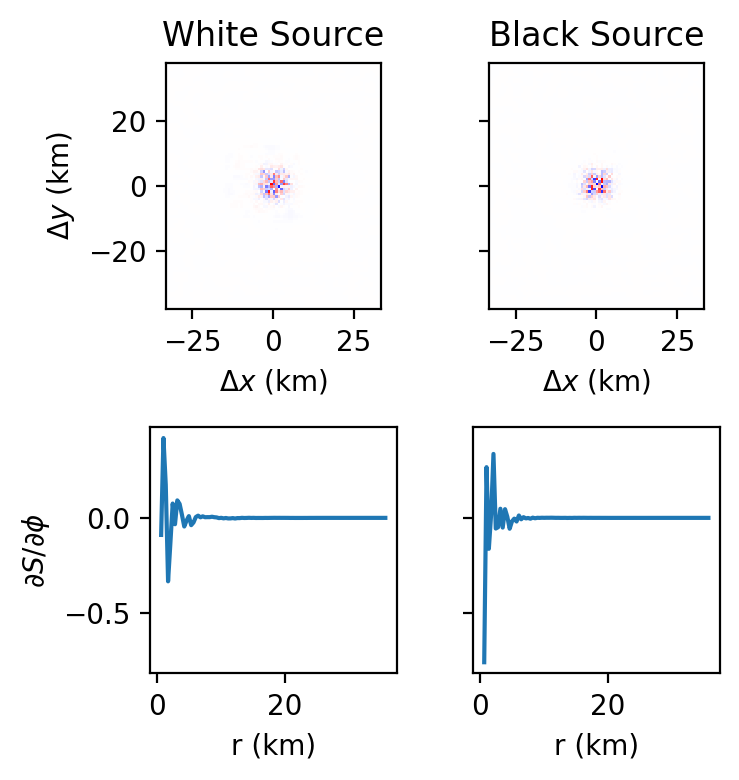

In [17]:
rgrid = np.linalg.norm(np.stack([x, y]), axis=0)
r = np.linspace(0, np.max(rgrid) / np.sqrt(2), 100)

fig, ax = plt.subplots(2, 2, figsize=(4, 4), dpi=200, 
                       sharey='row', sharex='row')

for i in range(len(G_S)):
    Gr = G_S[i,i]
    Gr = Gr / Gr.max()
    ax[0, i].pcolormesh(x, y, Gr,
                        vmin=-1, vmax=1, cmap='bwr')
    
    ax[0, i].set(
        xlabel=r'$\Delta x$ (km)',
        aspect='equal',
    )
    
    gr = np.zeros(len(r)-1)
    for j in range(len(r)-1):
        gr[j] = np.mean(Gr[(rgrid>=r[j])*(rgrid<r[j+1])])
    ax[1, i].plot(r[1:], gr)
    ax[1, i].set(xlabel='r (km)')
        
for i in range(2):
    ax[1,i].set_aspect(np.ptp(ax[1,i].get_xlim()) / np.ptp(ax[1,i].get_ylim()))

ax[0,0].set_ylabel(r'$\Delta y$ (km)')
ax[1,0].set_ylabel('$\\partial S / \\partial \\phi$')
ax[0,0].set_title('White Source')
ax[0,1].set_title('Black Source')
plt.tight_layout()